<h1>Adult encoding mask setup</h1>

In [19]:
# Functional imports
import os 
import numpy as np
import nibabel as nib

import data_prep_helpers
from plotting_helpers import plot_lateral_only

# Notebook specific imports
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
%autosave 5

Autosaving every 5 seconds


<h2>Save adult encoding results as a mask</h2>

In [20]:
# Set data location
directory = os.path.join(os.path.expanduser('~'), 'Documents', 'Data')
print('Data location:', directory)

# Load mask
gm_mask = nib.load(os.path.join(directory, 'group_gm_mask.nii.gz'))
print('Mask shape:', np.shape(gm_mask))

Data location: /Users/angira/Documents/Data
Mask shape: (79, 95, 68)


In [21]:
# Load thresholded results

full_adults = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'thresholded', 'adults_full_scores_gm_mask_thresholded05.npy'))
print('Full scores shape:', np.shape(full_adults))

moten_only_adults = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'thresholded', 'adults_moten_only_scores_gm_mask_thresholded05.npy'))
print('Motion only scores shape:', np.shape(moten_only_adults))

social_only_adults = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'thresholded', 'adults_social_only_scores_gm_mask_thresholded05.npy'))
print('Social only scores shape:', np.shape(social_only_adults))


Full scores shape: (367709,)
Motion only scores shape: (367709,)
Social only scores shape: (367709,)


In [23]:
# Convert to NIFTI volumes

full_adults_vol = data_prep_helpers.make_vol(full_adults, gm_mask)
print('Full vol:', np.shape(full_adults_vol))

moten_only_adults_vol = data_prep_helpers.make_vol(moten_only_adults, gm_mask)
print('Moten only vol:', np.shape(moten_only_adults_vol))

social_only_adults_vol = data_prep_helpers.make_vol(social_only_adults, gm_mask)
print('Social only vol:', np.shape(social_only_adults_vol))


Full vol: (79, 95, 68)
Moten only vol: (79, 95, 68)
Social only vol: (79, 95, 68)


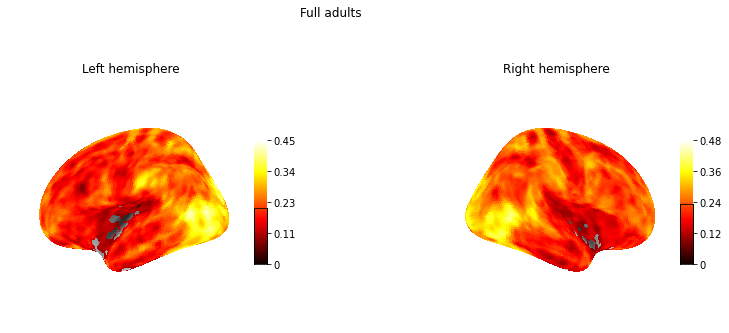

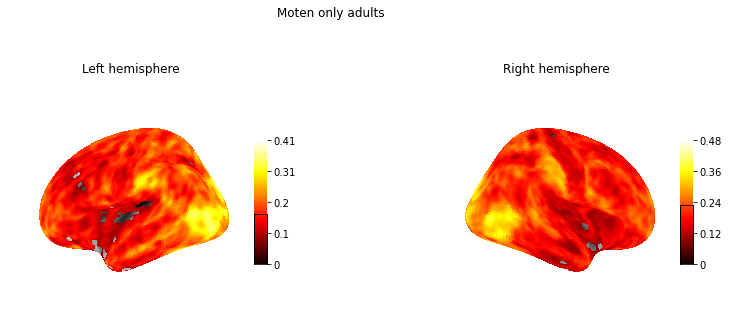

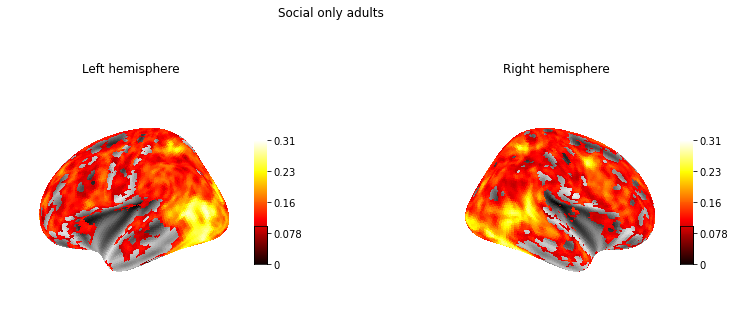

In [24]:
plot_lateral_only(vol=full_adults_vol, title='Full adults', vis_threshold=0)
plot_lateral_only(vol=moten_only_adults_vol, title='Moten only adults', vis_threshold=0)
plot_lateral_only(vol=social_only_adults_vol, title='Social only adults', vis_threshold=0)

In [8]:
# Save NIFTI volumes

full_adults_vol.to_filename(os.path.join(directory, 'encoding_masks', 'full_encoding_mask.nii.gz'))
moten_only_adults_vol.to_filename(os.path.join(directory, 'encoding_masks', 'moten_only_encoding_mask.nii.gz'))
social_only_adults_vol.to_filename(os.path.join(directory, 'encoding_masks', 'social_only_encoding_mask.nii.gz'))

<h2>Prep adult data for difference comparison</h2>

In [12]:
from brainiak import image
def mask_encoding_results(data, original_mask, target_mask):
    """
        Applies NIFTI mask to unthresholded encoding results
        Returns masked encoding results.
    """

    # Make boolean mask from NIFTI volume

    target_mask_bool = data_prep_helpers.make_boolean_mask(target_mask)

    # Apply mask to bold data 

    masked_data = []

    for subject in data:
        subject_nifti = data_prep_helpers.make_vol(subject, original_mask)
        masked_image = image.mask_image(subject_nifti, target_mask_bool)
        masked_data.append(masked_image)

    return masked_data

In [6]:
# Load unthresholded encoding results

full_adults_unthresholded = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'unthresholded', 'adults_full_scores_gm_mask.npy'))
print('Full scores shape:', np.shape(full_adults_unthresholded))

moten_only_adults_unthresholded = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'unthresholded', 'adults_moten_only_scores_gm_mask.npy'))
print('Motion only scores shape:', np.shape(moten_only_adults_unthresholded))

social_only_adults_unthresholded = np.load(os.path.join(
    directory, 'adults', 'encoding_results', 'unthresholded', 'adults_social_only_scores_gm_mask.npy'))
print('Social only scores shape:', np.shape(social_only_adults_unthresholded))


Full scores shape: (33, 367709)
Motion only scores shape: (33, 367709)
Social only scores shape: (33, 367709)


In [14]:
# Mask encoding results for difference comparison

full_encoding_results_masked_adults = mask_encoding_results(full_adults_unthresholded, gm_mask, full_adults_vol)
print('Full masked results:', np.shape(full_encoding_results_masked_adults))

moten_only_encoding_results_masked_adults = mask_encoding_results(moten_only_adults_unthresholded,
                                                                  gm_mask,
                                                                  moten_only_adults_vol)
print('Moten only masked results:', np.shape(moten_only_encoding_results_masked_adults))

social_only_encoding_results_masked_adults = mask_encoding_results(social_only_adults_unthresholded,
                                                                   gm_mask,
                                                                   social_only_adults_vol)
print('Social only masked results:', np.shape(social_only_encoding_results_masked_adults))

Full masked results: (33, 351759)
Moten only masked results: (33, 350449)
Social only masked results: (33, 294523)


In [16]:
# Save NIFTI volumes

np.save(os.path.join(directory, 'encoding_masks', 'adult_masked_encoding',
                     'adults_full_scores_adult_social_encoding_mask.npy'), full_encoding_results_masked_adults)

np.save(os.path.join(directory, 'encoding_masks', 'adult_masked_encoding',
                     'adults_moten_only_scores_adult_social_encoding_mask.npy'), 
        moten_only_encoding_results_masked_adults)

np.save(os.path.join(directory, 'encoding_masks', 'adult_masked_encoding', 
                     'adults_social_only_scores_adult_social_encoding_mask.npy'), 
        social_only_encoding_results_masked_adults)


<h2>Prep child data</h2>

In [5]:
def mask_trim_normalize(directory, subject_ids, mask):
    """
        Load nuisance-regressed bold data, apply a mask to it, then trim and normalize it.
        Returns masked, trimmed, normalized data.
    """
    bold_data = data_prep_helpers.load_clean_data(subject_range=subject_ids, directory=directory)
    masked_data = data_prep_helpers.apply_nifti_mask(bold_data=bold_data, mask=mask)
    trimmed_data = data_prep_helpers.trim_blank_trs(masked_data)
    normalized_data = data_prep_helpers.normalize_data(trimmed_data)
    return normalized_data

In [ ]:
# 3-4- year olds

normalized_bold_34yrs = mask_trim_normalize(os.path.join(directory, '3-4-yrs', 'raw_subjects'), 
                                             subject_ids=range(1,32), 
                                             mask=social_only_adults_vol)

print('Normalized data for 3-4 year olds', np.shape(normalized_bold_34yrs))
np.save(os.path.join(directory, '3-4-yrs', '3-4-yrs_normalized_data_adult_social_encoding_mask.npy'), 
        normalized_bold_34yrs)

print('Saved 3-4 year old data')


Normalized data for 3-4 year olds (31, 294523, 152)
Saved 3-4 year old data


In [12]:
# 5 year olds

normalized_bold_5yrs = mask_trim_normalize(os.path.join(directory, '5-yrs', 'raw_subjects'), 
                                             subject_ids=range(32,63), 
                                             mask=social_only_adults_vol)

print('Normalized data for 5 year olds', np.shape(normalized_bold_5yrs))
np.save(os.path.join(directory, '5-yrs', '5-yrs_normalized_data_adult_social_encoding_mask.npy'), 
        normalized_bold_5yrs)

print('Saved 5 year old data')


Normalized data for 5 year olds (31, 294523, 152)
Saved 5 year old data


In [8]:
# 7 year olds

ids_7yrs = [66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 79, 80, 81, 83, 84, 86, 88, 96, 99, 114, 116, 122]

normalized_bold_7yrs = mask_trim_normalize(os.path.join(directory, '7-yrs', 'raw_subjects'), 
                                             subject_ids=ids_7yrs, 
                                             mask=social_only_adults_vol)

print('Normalized data for 7 year olds', np.shape(normalized_bold_7yrs))
np.save(os.path.join(directory, '7-yrs', '7-yrs_normalized_data_adult_social_encoding_mask.npy'), 
        normalized_bold_7yrs)

print('Saved 7 year old data')


Normalized data for 7 year olds (23, 294523, 152)
Saved 7 year old data


In [9]:
# 8-12 year olds
ids_812yrs = [77, 78, 82, 85, 87, 89, 90, 91, 92, 93, 94, 95, 97, 98, 100, 101, 102, 103, 
               104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 117, 118, 119, 120, 121]
normalized_bold_812yrs = mask_trim_normalize(os.path.join(directory, '8-12-yrs', 'raw_subjects'), 
                                             subject_ids=ids_812yrs, 
                                             mask=social_only_adults_vol)

print('Normalized data for 8-12 year olds', np.shape(normalized_bold_812yrs))
np.save(os.path.join(directory, '8-12-yrs', '8-12-yrs_normalized_data_adult_social_encoding_mask.npy'), 
        normalized_bold_812yrs)

print('Saved 8-12 year old data')


Normalized data for 8-12 year olds (34, 294523, 152)
Saved 8-12 year old data
